In [2]:
# | code-summary: imports and settings
import hvplot.pandas
import hvplot.xarray
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import panel as pn
import pyspedas
import pytplot
import xarray as xr
from loguru import logger
from matplotlib.patches import Circle
from pytplot import get_data, options, tplot, tplot_copy

# import proplot as pplt # not compatible with pytplot


pn.extension(sizing_mode="stretch_width")

from utils import *

* Figure 1: two examples of discontinuity observations in ARTEMIS data (gse magnetic field, solar wind speed in gse, lmn magnetic field, ion omnidirection spectrum) with hodographs and fitting $B_m$ ($B_l$)
* Figure 2: distribution of $\kappa_m$, thickness $L$, $d_i$, distributions of energies estimated from L=\rhoi equation

For theoretical self-consistent model, the magnetic field is given by Bl=B0*tanh(z/L)
And we define the thickness **tanh**(1)=0.76
z=L, Bl=0.46*B0

Using the solar wind velocity projected onto the normal direction to the SWD surface, that of the minimum variance, $n$, we transform time to space $r_n$

Averaged ion velocity in mn direction (more reliable than n direction)

$v_{mn} = |\vec{v} - (\vec{v} \cdot \vec{l}) \vec{l}| = |v_m \vec{m} + v_n \vec{n}| = \sqrt{v_m^2+v_n^2} $

In [3]:
def calculate_RD_parameter(Bl, Bm, Bn=None, num_avg_points=8):
    """Calculate magnetic field parameters for rotation discontinuity (RD) identification.

    Args:
        Bl (xarray.DataArray): 'Bl' component of the magnetic field.
        Bm (xarray.DataArray): 'Bm' component of the magnetic field.
         Bn (xarray.DataArray, optional): 'Bn' component of the magnetic field. Defaults to None.
        num_avg_points (int): Number of points at the start and end of data for averaging.

    Returns:
        tuple: A tuple containing 'Bl_max' and 'Bm0', and 'Bn0' if 'Bn' was provided.
    """

    radius = np.sqrt(Bl**2 + Bm**2).mean(dim="time")

    # Calculate 'Bm0'
    Bm_start = Bm[:num_avg_points].mean(dim="time")
    Bm_end = Bm[-num_avg_points:].mean(dim="time")
    Bm0 = (Bm_start + Bm_end) / 2

    # Calculate 'Bl_max': average of the absolute values of 'Bl' at the start and end of the data
    # Bl_start = Bl[:num_avg_points].mean(dim="time")
    # Bl_end = Bl[-num_avg_points:].mean(dim="time")
    # Bl_max = (np.abs(Bl_start) + np.abs(Bl_end)) / 2

    # Calculate 'Bl_max': using radius, more reliable
    Bl_max = np.sqrt(radius**2 - Bm0**2)

    # Calculate 'Bn0' if 'Bn' is provided, else return 'Bl_max' and 'Bm0' only
    if Bn is not None:
        Bn0 = Bn.mean(dim="time")
        return Bl_max.values, Bm0.values, Bn0.values

    return Bl_max.values, Bm0.values

In [4]:
def hodographs(B1, B2):
    """Hodograms of the magnetic field components.

    Args:
        B1 (xr.DataArray): Magnetic field component 1.
        B2 (xr.DataArray): Magnetic field component 2.
    """

    radius = np.sqrt(B1**2 + B2**2).mean(dim="time")

    fig, ax = plt.subplots()
    (line,) = ax.plot(B1, B2, label="Observation")

    # Add a circle
    circle = Circle(
        (0, 0),
        radius,
        edgecolor="red",
        linestyle="--",
        facecolor="none",
        label=r"$B_m^2+B_l^2=B_{l,max}^2+B_{m,0}^2$",
    )

    circle = ax.add_artist(circle)

    ax.set_xlabel(f"{B1.attrs['long_name']} [{B1.attrs['units']}]")
    ax.set_ylabel(f"{B2.attrs['long_name']} [{B2.attrs['units']}]")
    ax.legend(handles=[line, circle], frameon=False)

    return fig, ax


def hodographs_BlBm(Bl, Bm):
    """Hodograms of the magnetic field components.

    Args:
        Bl (xr.DataArray): Magnetic field component 1.
        Bm (xr.DataArray): Magnetic field component 2.
    """

    fig, ax = hodographs(Bl, Bm)

    Bl_max, Bm0 = calculate_RD_parameter(Bl, Bm)

    plt.axvline(x=Bl_max, color="g", linestyle=":", label=r"$B_{l,max}$")
    plt.axvline(x=-Bl_max, color="g", linestyle=":", label=r"$-B_{l,max}$")
    plt.axhline(y=Bm0, color="g", linestyle=":", label=r"$B_{m,0}$")
    plt.text(Bl_max, Bm0, r"$B_{m,0}$", color="g")
    plt.text(-Bl_max, Bm0, r"$B_{l,max}$", color="g")
    plt.text(-Bl_max, Bm0, r"$-B_{l,max}$", color="g")

    return fig, ax

In [5]:
def get_thx_density(probe, trange, datatype="peem"):
    """get plasma density
    Note: better to get from electron mom data, peem_density, ion density is not as accurate
    """
    tstart, tstop = trange[0], trange[1]

    # Get plasma density
    tname = f"th{probe}_{datatype}_density"
    if not data_exists_tr(tname, *trange):
        pyspedas.themis.mom(probe=probe, trange=trange, varnames=[tname])

    thx_density = (
        get_data(tname, xarray=True).sortby("time").sel(time=slice(tstart, tstop))
    )  # Need to sort by time before slicing, otherwise error: KeyError: 'Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is not allowed.'
    thx_density_averaged = thx_density.mean(dim="time")
    return thx_density_averaged.values


def get_thx_max_flux_energy(probe, trange, datatype="peir"):
    tstart, tstop = trange[0], trange[1]

    tname = f"th{probe}_{datatype}_en_eflux"

    if not data_exists_tr(tname, *trange):
        pyspedas.themis.esa(probe=probe, trange=trange, varnames=[tname])

    thx_eflux = get_data(tname, xarray=True).sel(
        time=slice(tstart, tstop)
    )  # time_clip does not work for this variable (does not copy `spec_bins`)
    e_index = thx_eflux.sum(dim="time").argmax(dim="v_dim")
    thx_energy_max = thx_eflux.spec_bins.sel(v_dim=e_index).mean(dim="time")
    return thx_energy_max.values


# DEBUG
# get_data('thc_peem_density', xarray=True).hvplot()

In [6]:
def prcess_mva(event, plot=False, save=False, detail=True):
    # Define variables
    tstart, tstop, probe = event["tstart"], event["tstop"], event["probe"]
    trange = [tstart, tstop]
    datatype = event.get("datatype", "fgs")

    tplot_vars = ["thx_fgm", "thx_fgm_all"]

    # Convert magnetic field from GSM to MVA coordinates
    mva_data = thx_mag_prod(probe, tstart, tstop, datatype, coord="mva")

    Bl = mva_data.sel(v_dim=0)
    Bm = mva_data.sel(v_dim=1)
    Bn = mva_data.sel(v_dim=2)
    Bl.attrs["long_name"] = "$B_l$"
    Bl.attrs["units"] = "nT"
    Bm.attrs["long_name"] = "$B_m$"
    Bm.attrs["units"] = "nT"

    Bl_max, Bm0, Bn0 = calculate_RD_parameter(Bl, Bm, Bn)

    # Initialize dictionary for results
    result_dict = {}
    result_dict["Bl_max"] = Bl_max
    result_dict["Bm0"] = Bm0
    result_dict["Bn0"] = Bn0

    # Calculate detail if detail flag is set to True
    if detail:
        # Define variables related to ion velocity and flux
        thx_ion_vel_tname = f"th{probe}_peir_velocity_gsm"

        if not data_exists_tr(thx_ion_vel_tname, *trange):
            pyspedas.themis.esa(
                probe=probe, trange=trange, varnames=[thx_ion_vel_tname]
            )

        # Convert ion velocity from GSM to MVA coordinates
        tplot_copy(thx_ion_vel_tname, "thx_ion_vel")
        time_clip("thx_ion_vel", tstart, tstop, suffix="")
        tvector_rotate("thx_fgm_mva_mat", "thx_ion_vel")
        tplot_vars += ["thx_ion_vel", "thx_ion_vel_rot"]
        # Get averaged ion velocity in the normal direction
        # thx_ion_vel_n = get_data("thx_ion_vel_rot", xarray=True).sel(v_dim=2).mean(dim="time").values
        # print_string += f" 'thx_ion_vel_n': {thx_ion_vel_n:.2f},"

        # Get averaged ion velocity in mn direction (more reliable than n direction)
        thx_ion_vel_mn_ts = get_data("thx_ion_vel_rot", xarray=True).sel(v_dim=[1, 2])
        thx_ion_vel_mn = (
            np.sqrt(np.square(thx_ion_vel_mn_ts).sum(dim="v_dim"))
            .mean(dim="time")
            .values
        )
        result_dict["thx_ion_vel_mn"] = thx_ion_vel_mn

        # Calculate thickness
        c1 = 0.76
        time = mva_data.time.to_numpy().astype("datetime64[ns]")
        t_pos = time[np.abs(Bl + c1 * Bl_max).argmin(dim="time")]
        t_neg = time[np.abs(Bl - c1 * Bl_max).argmin(dim="time")]
        L = (
            thx_ion_vel_mn * ((t_pos - t_neg).astype("float64"))
        ) * 1e-9  # L = (thx_ion_vel_n * ((t_pos - t_neg).astype("float64"))) * 1e-9
        result_dict["L"] = L

        # Get max ion energy flux and plasma density
        result_dict["thx_ion_energy_max"] = get_thx_max_flux_energy(probe, trange)
        result_dict["n_p"] = get_thx_density(probe, trange)

    # Plotting the data
    if plot:
        # Calculate distance
        t_origin = time[np.abs(Bl).argmin(dim="time")]
        distance = (
            thx_ion_vel_mn * ((time - t_origin).astype("float64"))
        ) * 1e-9  # distance = (thx_ion_vel_n * ((time - t_origin).astype("float64"))) * 1e-9
        pytplot.store_data("distance", data={"x": time, "y": distance})
        options("distance", "ysubtitle", "[km]")

        filename = f"../figures/{tstart}" if save else ""
        var_label = "distance" if detail else ""
        tplot(tplot_vars, var_label=var_label, save_svg=filename)

        fig, ax = hodographs_BlBm(Bl, Bm)
        fig.savefig(f"../figures/{tstart}_mva.svg") if save else None

    # logger.info(print_string)
    # Convert numpy array values to native Python types
    for key in result_dict:
        if isinstance(result_dict[key], np.ndarray) and result_dict[key].size == 1:
            result_dict[key] = result_dict[key].item()

    return result_dict

22-Jul-23 14:01:25: /Users/zijin/mambaforge/envs/cool_solar_wind/lib/python3.10/site-packages/pytplot/MPLPlotter/tplot.py:623: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  out_ticks.append('{:.2f}'.format(var_xr.interp(coords={'time': time}, kwargs={'fill_value': 'extrapolate', 'bounds_error': False}).values))

22-Jul-23 14:01:25: /Users/zijin/mambaforge/envs/cool_solar_wind/lib/python3.10/site-packages/pytplot/MPLPlotter/tplot.py:623: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is

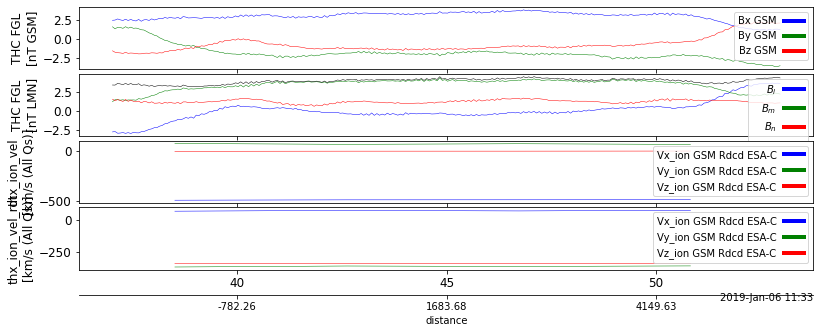

{'Bl_max': 3.230087591755617,
 'Bm0': 1.7689997499457184,
 'Bn0': 1.2022550948066542,
 'thx_ion_vel_mn': 493.18811615393975,
 'L': -6842.985111635914,
 'thx_ion_energy_max': 1345.454345703125,
 'n_p': 4.890736689998141}

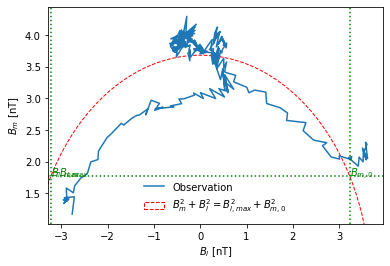

In [14]:
raw_events = [
    {
        "probe": "c",
        "tstart": "2019-01-06 11:33:37",
        "tstop": "2019-01-06 11:33:53",
        "datatype": "fgl",
        "Bl_max": 3.23,
        "Bm0": 1.77,
        "Bn0": 1.20,
        "thx_ion_vel_n": -337.90,
        "L": 4688.31,
        "thx_ion_energy_max": 1345.45,
        "n_p": 4.89,
        "quality": "soso, waving",
    },
    {
        "probe": "c",
        "tstart": "2019-01-06 11:47:00",
        "tstop": "2019-01-06 11:47:15",
        "datatype": "fgl",
        "Bl_max": 2.78,
        "Bm0": 3.63,
        "Bn0": 2.29,
        "thx_ion_vel_n": -283.08,
        "L": 1857.74,
        "thx_ion_energy_max": 1345.45,
        "n_p": 4.50,
        "quality": "soso",
    },
    {
        "probe": "c",
        "tstart": "2019-01-06 15:54:05",
        "tstop": "2019-01-06 15:54:39",
        "datatype": "fgl",
        "Bl_max": 2.77,
        "Bm0": 1.97,
        "Bn0": 6.38,
        "thx_ion_vel_n": -85.12,
        "L": -2000.34,
        "thx_ion_energy_max": 1345.45,
        "n_p": 0.64,
        "quality": "soso",
    },
    {
        "probe": "c",
        "tstart": "2019-01-06 16:08:55",
        "tstop": "2019-01-06 16:09:13",
        "datatype": "fgl",
        "Bl_max": 2.08,
        "Bm0": 6.26,
        "Bn0": 2.18,
        "thx_ion_vel_n": -187.13,
        "L": -2070.15,
        "thx_ion_energy_max": 1771.15,
        "n_p": 0.55,
        "quality": "soso",
    },
    {
        "probe": "c",
        "tstart": "2019-01-06 16:37:01",
        "tstop": "2019-01-06 16:38:10",
        "datatype": "fgl",
        "Bl_max": 3.30,
        "Bm0": -4.44,
        "Bn0": 4.79,
        "thx_ion_vel_n": -444.92,
        "L": 16045.03,
        "thx_ion_energy_max": 2332.04,
        "n_p": 0.48,
        "quality": "soso",
    },
    {
        "probe": "c",
        "tstart": "2019-01-06 16:39:06",
        "tstop": "2019-01-06 16:39:45",
        "datatype": "fgl",
        "Bl_max": 3.00,
        "Bm0": 3.83,
        "Bn0": 5.55,
        "thx_ion_vel_n": -353.01,
        "L": -7567.59,
        "thx_ion_energy_max": 1345.45,
        "n_p": 0.86,
        "quality": "soso",
    },
    {
        "probe": "c",
        "tstart": "2019-01-06T17:40:50",
        "tstop": "2019-01-06T17:41:50",
        "datatype": "fgl",
        "Bl_max": 3.71,
        "Bm0": 1.35,
        "Bn0": -0.63,
        "thx_ion_vel_n": -343.57,
        "L": -13871.65,
        "thx_ion_energy_max": 1345.45,
        "n_p": 5.85,
        "quality": "soso, waving, large interval",
    },
    {
        "probe": "c",
        "tstart": "2019-01-06T17:46:40",
        "tstop": "2019-01-06T17:46:55",
        "datatype": "fgl",
        "Bl_max": 3.82,
        "Bm0": 1.68,
        "Bn0": 1.34,
        "thx_ion_vel_n": -503.10,
        "L": 1792.29,
        "thx_ion_energy_max": 1771.15,
        "n_p": 4.01,
        "quality": "soso",
    },
    {
        "probe": "c",
        "tstart": "2019-01-06T17:48:00",
        "tstop": "2019-01-06T17:48:40",
        "datatype": "fgl",
        "Bl_max": 3.59,
        "Bm0": 2.99,
        "Bn0": 0.87,
        "thx_ion_vel_n": -513.37,
        "L": 6288.79,
        "thx_ion_energy_max": 1771.15,
        "n_p": 3.75,
        "quality": "soso",
    },
    {
        "probe": "c",
        "tstart": "2019-01-06T19:26:14",
        "tstop": "2019-01-06T19:26:35",
        "datatype": "fgs",
        "Bl_max": 2.16,
        "Bm0": -3.05,
        "Bn0": 3.20,
        "thx_ion_vel_n": -170.46,
        "L": 1398.71,
        "thx_ion_energy_max": 1345.45,
        "n_p": 5.33,
        "quality": "soso, low resolution",
    },
    {
        "probe": "c",
        "tstart": "2019-01-06T19:55:21",
        "tstop": "2019-01-06T19:55:29",
        "datatype": "fgl",
        "Bl_max": 3.53,
        "Bm0": -1.77,
        "Bn0": -0.07,
        "thx_ion_vel_n": 410.07,
        "L": -1460.86,
        "thx_ion_energy_max": 1345.45,
        "n_p": 4.90,
        "quality": "good",
    },
    {
        "probe": "c",
        "tstart": "2019-01-06T19:59:45",
        "tstop": "2019-01-06T19:59:50",
        "datatype": "fgl",
        "Bl_max": 1.70,
        "Bm0": 0.86,
        "Bn0": -3.94,
        "thx_ion_vel_n": 340.09,
        "L": -233.81,
        "thx_ion_energy_max": 1345.45,
        "n_p": 3.96,
        "quality": "bad",
    },
    {
        "probe": "c",
        "tstart": "2019-01-06T20:08:15",
        "tstop": "2019-01-06T20:08:25",
        "datatype": "fgl",
        "Bl_max": 1.81,
        "Bm0": 3.71,
        "Bn0": 0.07,
        "thx_ion_vel_n": -332.01,
        "L": -1473.31,
        "thx_ion_energy_max": 1345.45,
        "n_p": 4.43,
        "quality": "soso",
    },
    {
        "probe": "c",
        "tstart": "2019-01-06T20:14:27.40",
        "tstop": "2019-01-06T20:14:33",
        "datatype": "fgl",
        "Bl_max": 3.08,
        "Bm0": -1.41,
        "Bn0": -1.12,
        "L": -1053.43,
        "thx_ion_vel_n": 432.18,
        "thx_ion_energy_max": 1771.15,
        "n_p": 4.71,
        "quality": "good",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T06:02:30",
        "tstop": "2019-01-07T06:05:00",
        "datatype": "fgs",
        "Bl_max": 1.44,
        "Bm0": 2.10,
        "Bn0": 1.27,
        "thx_ion_energy_max": 1345.45,
        "quality": "bad",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T06:27:00",
        "tstop": "2019-01-07T06:27:40",
        "datatype": "fgs",
        "Bl_max": 2.05,
        "Bm0": -2.49,
        "Bn0": -0.35,
        "thx_ion_energy_max": 1345.45,
        "quality": "bad",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T09:13:11",
        "tstop": "2019-01-07T09:13:40",
        "datatype": "fgl",
        "Bl_max": 1.75,
        "Bm0": -2.28,
        "Bn0": -1.68,
        "L": -6610.43,
        "thx_ion_vel_n": 431.70,
        "thx_ion_energy_max": 1345.45,
        "quality": "soso",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T09:20:08",
        "tstop": "2019-01-07T09:20:22",
        "datatype": "fgl",
        "Bl_max": 1.41,
        "Bm0": 2.59,
        "Bn0": -0.02,
        "L": 1606.09,
        "thx_ion_vel_n": -133.15,
        "thx_ion_energy_max": 1345.45,
        "quality": "soso",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T09:24:15",
        "tstop": "2019-01-07T09:24:45",
        "datatype": "fgl",
        "Bl_max": 1.72,
        "Bm0": -1.56,
        "Bn0": 2.45,
        "L": 1495.13,
        "thx_ion_vel_n": -72.27,
        "thx_ion_energy_max": 1345.45,
        "quality": "soso",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T09:31:57.30",
        "tstop": "2019-01-07T09:32:05",
        "datatype": "fgl",
        "Bl_max": 1.86,
        "Bm0": -2.62,
        "Bn0": -0.67,
        "L": -885.86,
        "thx_ion_vel_n": 308.12,
        "thx_ion_energy_max": 1345.45,
        "quality": "good",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T09:34:28",
        "tstop": "2019-01-07T09:34:31",
        "datatype": "fgl",
        "Bl_max": 1.18,
        "Bm0": 1.21,
        "Bn0": 2.99,
        "L": 449.99,
        "thx_ion_vel_n": -378.94,
        "thx_ion_energy_max": 1345.45,
        "quality": "soso, large Bn",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T09:38:31",
        "tstop": "2019-01-07T09:38:45",
        "datatype": "fgl",
        "Bl_max": 1.33,
        "Bm0": -1.26,
        "Bn0": -2.48,
        "L": 3494.37,
        "thx_ion_vel_n": 411.10,
        "thx_ion_energy_max": 1345.45,
        "quality": "soso, large Bn",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T09:40:31",
        "tstop": "2019-01-07T09:41:02",
        "datatype": "fgl",
        "Bl_max": 2.03,
        "Bm0": -2.22,
        "Bn0": -0.44,
        "L": 9551.26,
        "thx_ion_vel_n": -428.07,
        "thx_ion_energy_max": 1345.45,
        "quality": "soso, sensitive to time interval",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T09:41:17",
        "tstop": "2019-01-07T09:41:35",
        "datatype": "fgl",
        "Bl_max": 2.74,
        "Bm0": -1.42,
        "Bn0": 0.25,
        "L": -1994.58,
        "thx_ion_vel_n": -301.07,
        "thx_ion_energy_max": 1345.45,
        "quality": "good",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T09:44:45",
        "tstop": "2019-01-07T09:44:57",
        "datatype": "fgl",
        "Bl_max": 2.16,
        "Bm0": 2.32,
        "Bn0": 0.15,
        "L": -1300.35,
        "thx_ion_vel_n": -288.97,
        "thx_ion_energy_max": 1345.45,
        "quality": "good",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T09:45:02",
        "tstop": "2019-01-07T09:45:11",
        "datatype": "fgl",
        "Bl_max": 2.65,
        "Bm0": 1.44,
        "Bn0": -0.12,
        "L": 1686.95,
        "thx_ion_vel_n": -391.18,
        "thx_ion_energy_max": 1345.45,
        "quality": "good",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T10:05:06.30",
        "tstop": "2019-01-07T10:05:12",
        "datatype": "fgl",
        "Bl_max": 1.77,
        "Bm0": -2.84,
        "Bn0": 0.75,
        "L": -1349.08,
        "thx_ion_vel_n": 423.24,
        "thx_ion_energy_max": 1345.45,
        "quality": "soso",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T10:08:29",
        "tstop": "2019-01-07T10:08:47",
        "datatype": "fgl",
        "Bl_max": 2.07,
        "Bm0": 2.70,
        "Bn0": -0.14,
        "L": 6583.74,
        "thx_ion_vel_n": -450.17,
        "thx_ion_energy_max": 1345.45,
        "quality": "good",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T10:33:22",
        "tstop": "2019-01-07T10:33:26",
        "datatype": "fgl",
        "Bl_max": 1.45,
        "Bm0": 2.41,
        "Bn0": 2.74,
        "L": 511.43,
        "thx_ion_vel_n": -263.97,
        "thx_ion_energy_max": 1345.45,
        "quality": "soso, large Bn",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T10:50:10",
        "tstop": "2019-01-07T10:50:24",
        "datatype": "fgl",
        "Bl_max": 2.88,
        "Bm0": 1.29,
        "Bn0": 0.72,
        "L": -1637.17,
        "thx_ion_vel_n": -327.43,
        "thx_ion_energy_max": 1345.45,
        "quality": "good",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T10:52:12",
        "tstop": "2019-01-07T10:52:18",
        "datatype": "fgl",
        "Bl_max": 2.65,
        "Bm0": 1.96,
        "Bn0": -0.33,
        "L": 445.06,
        "thx_ion_vel_n": -245.55,
        "thx_ion_energy_max": 1345.45,
        "quality": "good",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T10:53:21",
        "tstop": "2019-01-07T10:56:12",
        "datatype": "fgl",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T10:57:47",
        "tstop": "2019-01-07T11:03:59",
        "datatype": "fgl",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T11:01:47",
        "tstop": "2019-01-07T11:09:09",
        "datatype": "fgl",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T11:11:24",
        "tstop": "2019-01-07T11:14:25",
        "datatype": "fgl",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T11:11:24",
        "tstop": "2019-01-07T11:14:25",
        "datatype": "fgl",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T11:22:48",
        "tstop": "2019-01-07T11:24:32",
        "datatype": "fgl",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T11:29:38",
        "tstop": "2019-01-07T11:34:32",
        "datatype": "fgl",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T11:37:33",
        "tstop": "2019-01-07T11:42:21",
        "datatype": "fgl",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T11:41:01",
        "tstop": "2019-01-07T11:45:43",
        "datatype": "fgl",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T11:59:26",
        "tstop": "2019-01-07T12:03:36",
        "datatype": "fgl",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T12:14:31",
        "tstop": "2019-01-07T12:17:54",
        "datatype": "fgl",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T12:18:21",
        "tstop": "2019-01-07T12:19:12",
        "datatype": "fgl",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T12:21:10",
        "tstop": "2019-01-07T12:23:13",
        "datatype": "fgl",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T12:27:25",
        "tstop": "2019-01-07T12:31:27",
        "datatype": "fgl",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T12:31:11",
        "tstop": "2019-01-07T12:33:13",
        "datatype": "fgl",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T12:38:07",
        "tstop": "2019-01-07T12:41:37",
        "datatype": "fgl",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T12:42:25",
        "tstop": "2019-01-07T12:44:35",
        "datatype": "fgl",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T12:45:41",
        "tstop": "2019-01-07T12:49:11",
        "datatype": "fgl",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T12:51:18",
        "tstop": "2019-01-07T12:53:52",
        "datatype": "fgl",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T12:57:47",
        "tstop": "2019-01-07T13:01:04",
        "datatype": "fgl",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T13:02:31",
        "tstop": "2019-01-07T13:04:59",
        "datatype": "fgl",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T13:05:27",
        "tstop": "2019-01-07T13:06:13",
        "datatype": "fgl",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T13:06:04",
        "tstop": "2019-01-07T13:08:42",
        "datatype": "fgl",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T13:20:13",
        "tstop": "2019-01-07T13:23:52",
        "datatype": "fgl",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T13:25:55",
        "tstop": "2019-01-07T13:32:47",
        "datatype": "fgl",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T13:48:13",
        "tstop": "2019-01-07T13:51:50",
        "datatype": "fgl",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T13:58:05",
        "tstop": "2019-01-07T14:00:31",
        "datatype": "fgl",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T14:00:33",
        "tstop": "2019-01-07T14:01:35",
        "datatype": "fgl",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T14:09:36",
        "tstop": "2019-01-07T14:12:33",
        "datatype": "fgl",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T14:15:36",
        "tstop": "2019-01-07T14:17:18",
        "datatype": "fgl",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T14:22:06",
        "tstop": "2019-01-07T14:23:46",
        "datatype": "fgl",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T14:25:06",
        "tstop": "2019-01-07T14:27:52",
        "datatype": "fgl",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T14:34:40",
        "tstop": "2019-01-07T14:38:08",
        "datatype": "fgl",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T14:37:53",
        "tstop": "2019-01-07T14:45:51",
        "datatype": "fgl",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T15:08:59",
        "tstop": "2019-01-07T15:25:45",
        "datatype": "fgl",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T16:16:22",
        "tstop": "2019-01-07T17:02:42",
        "datatype": "fgl",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T17:51:52",
        "tstop": "2019-01-07T18:15:32",
        "datatype": "fgl",
    },
    {
        "probe": "c",
        "tstart": "2019-01-07T18:09:19",
        "tstop": "2019-01-07T18:24:20",
        "datatype": "fgl",
    },
    {
        "probe": "c",
        "tstart": "2020-02-19 00:25:40",
        "tstop": "2020-02-19 00:25:55",
        "datatype": "fgl",
        "Bl_max": 4.768192738110849,
        "Bm0": 7.686530972594898,
        "Bn0": 1.9736601167997532,
        "quality": "waving",
        "thx_ion_vel_mn": 318.1195455936361,
        "thx_ion_energy_max": 589.7517700195312,
    },
    {
        "probe": "c",
        "tstart": "2020-02-19 04:39:00",
        "tstop": "2020-02-19 04:39:40",
        "datatype": "fgs",
        "Bl_max": 4.449951459371009,
        "Bm0": 6.549976122277972,
        "Bn0": -0.7438622943608969,
    },
    {
        "probe": "c",
        "tstart": "2020-02-19 06:27:32",
        "tstop": "2020-02-19 06:27:38",
        "datatype": "fgl",
        "quality": "good",
        "Bl_max": 4.646400176724599,
        "Bm0": -3.857887514402382,
        "Bn0": 1.5164913620549683,
        "L": 544.5,
        "energy_max": 1022.2870483398438,
    },
    {
        "probe": "c",
        "tstart": "2020-02-19 08:19:09",
        "tstop": "2020-02-19 08:19:13",
        "datatype": "fgl",
        "Bl_max": 3.999922551838544,
        "Bm0": -4.129371790979183,
        "Bn0": 0.39520660997553475,
        "quality": "good",
        "thx_ion_vel_mn": 284.2360012191073,
        "thx_ion_energy_max": 1345.8341064453125,
    },
    {
        "probe": "c",
        "tstart": "2020-02-20 02:35:37",
        "tstop": "2020-02-20 02:35:53",
        "datatype": "fgl",
        "Bl_max": 2.6859416341815625,
        "Bm0": -1.9787655396978097,
        "Bn0": 0.5099011624613212,
        "quality": "good",
        "thx_ion_vel_mn": 383.2802191661173,
        "thx_ion_energy_max": 776.968505859375,
    },
    {
        "probe": "c",
        "tstart": "2021-01-12 03:07:32",
        "tstop": "2021-01-12 03:07:35",
        "datatype": "fgl",
        "quality": "soso",
        "Bl_max": 2.891977682401448,
        "Bm0": -4.843614311016452,
        "Bn0": -1.947426599144735,
    },
    {
        "probe": "c",
        "tstart": "2021-01-12 06:28:15",
        "tstop": "2021-01-12 06:28:20",
        "datatype": "fgl",
        "quality": "soso",
        "Bl_max": 2.508285900921373,
        "Bm0": 4.508437164205484,
        "Bn0": -0.605711593677448,
    },
    {
        "probe": "c",
        "tstart": "2021-01-13 07:45:17",
        "tstop": "2021-01-13 07:45:30",
        "datatype": "fgl",
        "quality": "bad",
        "Bl_max": 2.609658135051226,
        "Bm0": 4.624308552001889,
        "Bn0": -1.1605201660183038,
    },
    {
        "probe": "c",
        "tstart": "2021-01-14 04:01:50",
        "tstop": "2021-01-14 04:03:00",
        "datatype": "fgl",
        "quality": "soso",
        "Bl_max": 3.4453850747655315,
        "Bm0": 2.561887235949561,
        "Bn0": -0.22949910219023723,
    },
    {
        "probe": "c",
        "tstart": "2021-03-12 15:37:07",
        "tstop": "2021-03-12 15:37:30",
        "datatype": "fgl",
        "Bl_max": 1.7684883124009274,
        "Bm0": -3.7139271039491604,
        "Bn0": -0.863374872170262,
        "quality": "bad",
    },
    {
        "probe": "c",
        "tstart": "2021-04-03 04:57:40",
        "tstop": "2021-04-03 04:57:55",
        "datatype": "fgl",
        "quality": "good",
        "Bl_max": 2.5026316689074886,
        "Bm0": -1.9860704570152035,
        "Bn0": -0.06739101833563413,
    },
    {
        "probe": "c",
        "tstart": "2021-04-16 19:19:05",
        "tstop": "2021-04-16 19:19:15",
        "datatype": "fgl",
        "quality": "good",
        "Bl_max": 8.973848917338131,
        "Bm0": 3.7841571009302024,
        "Bn0": 0.3380442557008978,
    },
    {
        "probe": "c",
        "tstart": "2021-04-18 20:41:33",
        "tstop": "2021-04-18 20:41:35.30",
        "datatype": "fgl",
        "Bl_max": 2.3629257220712265,
        "Bm0": 4.895827328159069,
        "Bn0": -0.7405799781966877,
        "quality": "bad",
    },
    {
        "probe": "c",
        "tstart": "2022-04-04 18:58:16",
        "tstop": "2022-04-04 18:58:22",
        "datatype": "fgl",
        "Bl_max": 2.459880337188561,
        "Bm0": -2.931467267219719,
        "Bn0": -0.9352026864241058,
        "quality": "good",
    },
]

prcess_mva(raw_events[0], plot=True)

In [36]:
def test():
    event = events[0]
    tstart, tstop, probe = event["tstart"], event["tstop"], event["probe"]
    trange = [tstart, tstop]
    logger.info(f"trange: {trange}")

    # Get plasma density
    thx_density_tname = f"th{probe}_peem_density"
    "thc_peem_density"
    mom_vars = pyspedas.themis.mom(
        probe=probe, trange=trange, varnames=[thx_density_tname]
    )
    thx_density = get_data(thx_density_tname, xarray=True).sel(
        time=slice(tstart, tstop)
    )
    thx_density_averaged = thx_density.mean(dim="time")
    logger.info(f"thx_density_averaged: {thx_density_averaged}")
    return thx_density.hvplot()
    # tplot(['thd_peim_velocity_gsm', 'thd_peim_density'])
    # thd_peim_density = pytplot.get_data('thd_peim_density')


# test()

## Example Event

In [ ]:
event = {
    "probe": "c",
    "tstart": "2021-04-03T04:57:40",
    "tstop": "2021-04-03T04:57:55",
    "datatype": "fgl",
    "quality": "good",
    'Bl_max': 2.5026316689074886, 'Bm0': -1.9860704570152035, 'Bn0': -0.06739101833563413
}

record = 1
plot = True

if record:
    events.append(event)
    
if plot:
    # plot_mva(event, backend="matplotlib",detail=True, save=True)
    # plot_mva(event, save=True)

## Statistical analysis

In [47]:
events = [
    {
        "probe": "c",
        "tstart": "2019-01-06 11:27:29.30",
        "tstop": "2019-01-06 11:27:45",
        "datatype": "fgl",
        "quality": "soso, small waving",
    },
    {
        "probe": "c",
        "tstart": "2019-01-06 10:41:27",
        "tstop": "2019-01-06 10:41:31",
        "datatype": "fgl",
        "quality": "soso",
        "note": "background Bl0?",
    },
    {
        "probe": "c",
        "tstart": "2019-01-06 10:39:29",
        "tstop": "2019-01-06 10:39:38",
        "datatype": "fgl",
        "quality": "bad",
    },
    {
        "probe": "c",
        "tstart": "2019-01-06 10:39:08",
        "tstop": "2019-01-06 10:39:15",
        "datatype": "fgl",
        "quality": "good",
        "note": "background Bl0?",
    },
    {
        "probe": "c",
        "tstart": "2019-01-05 09:21:26",
        "tstop": "2019-01-05 09:21:32",
        "datatype": "fgl",
        "quality": "bad",
    },
    {
        "probe": "c",
        "tstart": "2019-01-05 09:14:50",
        "tstop": "2019-01-05 09:14:55",
        "datatype": "fgl",
        "quality": "good",
    },
    {
        "probe": "c",
        "tstart": "2019-01-05 09:09:12",
        "tstop": "2019-01-05 09:09:25",
        "datatype": "fgl",
        "quality": "soso, waving",
    },
    {
        "probe": "c",
        "tstart": "2019-01-05 09:05:41",
        "tstop": "2019-01-05 09:05:47",
        "datatype": "fgl",
        "quality": "soso, large Bn0",
    },
    {
        "probe": "c",
        "tstart": "2019-01-05 07:43:25",
        "tstop": "2019-01-05 07:43:35",
        "datatype": "fgl",
        "quality": "bad, magnitude dipping",
    },
    {
        "probe": "c",
        "tstart": "2019-01-05 07:11:29",
        "tstop": "2019-01-05 07:11:35",
        "datatype": "fgl",
        "quality": "good, waving",
    },
    {
        "probe": "c",
        "tstart": "2019-01-01 05:22:51",
        "tstop": "2019-01-01 05:22:55",
        "datatype": "fgl",
        "quality": "soso",
        "note": "background Bl0?",
    },
    {
        "probe": "c",
        "tstart": "2019-01-01 03:49:04.30",
        "tstop": "2019-01-01 03:49:11",
        "datatype": "fgl",
        "quality": "soso",
    },
    {
        "probe": "c",
        "tstart": "2019-01-01 03:47:57",
        "tstop": "2019-01-01 03:48:01",
        "datatype": "fgl",
        "quality": "bad",
        "note": "background Bl0?",
    },
    {
        "probe": "c",
        "tstart": "2019-01-01 00:34:16",
        "tstop": "2019-01-01 00:34:26",
        "datatype": "fgl",
        "quality": "good",
    },
]

for event in events:
    try:
        result_dict = prcess_mva(event, plot=False, save=False)
        event.update(result_dict)
    except Exception as e:
        print(f"Error processing event {event}: {e}")

In [48]:
df = pd.DataFrame(events)

In [42]:
from astropy import units as u
from plasmapy.formulary.lengths import inertial_length

df["k_m"] = np.abs(df["Bm0"] / df["Bl_max"])
df["k_n"] = np.abs(df["Bn0"] / df["Bl_max"])
df["d_i"] = (
    inertial_length(df["n_p"].to_numpy() * u.cm**-3, particle="proton").to(u.km).value
)
df["L/d_i"] = df["L"] / df["d_i"]
df.describe()

KeyError: 'n_p'

<AxesSubplot:ylabel='Frequency'>

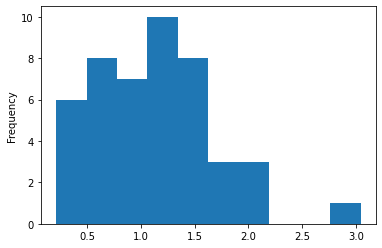

In [265]:
# histogram of k_m, with values larger than 1 belonging to the same group
df["k_m"].plot(kind="hist")
# df["k_n"].plot(kind="hist")

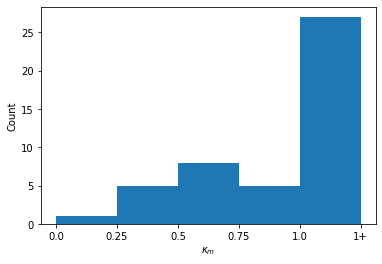

In [267]:
# histogram of k_m, with values larger than 1 belonging to the same group
# np.abs(df["k_m"]).plot(kind="hist")

fig, axs = plt.subplots()

bin_space = 0.25

bins = np.arange(0, 1 + 2 * bin_space, bin_space)
ticks = np.arange(0, 1 + bin_space, bin_space).tolist()
ticks.append("1+")

# Modify k_m so all values larger than 1 are set to 2
k_m_grouped = [x if x <= 1 else 1 + bin_space / 2 for x in np.abs(df["k_m"])]

# Then, define bins from 0 to 1 in steps of 0.25, and an additional bin for all values >1
axs.hist(k_m_grouped, bins=bins)

axs.set_xlabel(r"$\kappa_m$")
axs.set_ylabel("Count")

# axs.format(
#     xlabel=r"$\kappa_m$",
#     ylabel="Count",
# )

# Adjust x-axis labels to reflect the actual bins in the data
plt.xticks(bins, ticks)

# fig.savefig("../figures/k_m_hist.svg")

plt.show()